### Download Data

The data is taken from http://archive.ics.uci.edu/ml/machine-learning-databases/00240/, but you can have it in the form of the UCI-HAR-Dataset.zip.

Extract it to the folder of your notebook with the solution (or suitably adjust the paths to training and test data specified below (TRAIN, TEST).  

Spcifically, the split into training and testing data is already done. The dataset contains 7352 training and 2947 test samples.  

Each sample consists of 9 timeseries of float values, each of length 128.

The 9 timeseries are collected by an accelerometer and a gyroscope that contain information about the motion and the orientation, respectively.

In [9]:
# Useful Constants
TRAIN = "UCI HAR Dataset/train/"
TEST = "UCI HAR Dataset/test/"

# x-values, 'signals'
# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]
X_train_signals_paths = [TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES]
X_test_signals_paths =  [TEST  + "Inertial Signals/" + signal + "test.txt"  for signal in INPUT_SIGNAL_TYPES]


# y-values, 'labels'
#Output classes to learn how to classify
LABELS = [
    "WALKING",
    "WALKING_UPSTAIRS",
    "WALKING_DOWNSTAIRS",
    "SITTING",
    "STANDING",
    "LAYING"
]
N_CLASSES = len(LABELS)
y_train_path = TRAIN + "y_train.txt"
y_test_path  = TEST  + "y_test.txt"

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import keras

import os

In [11]:
# Load "X" (the neural network's training and testing inputs)
def load_X(X_signals_paths):
    X_signals = []
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)

In [59]:
# Load "y" (the neural network's training and testing outputs)
def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]],
        dtype=np.int32
    )
    file.close()
    # Substract 1 to each output class for friendly 0-based indexing
    return y_ - 1

def one_hot(y, n_classes):
    '''
    For the given label y (0<=y<n_classes) create a one-hot vector of lenght n_classes.
    '''
    ### START YOUR CODE 
    y_hot = keras.utils.to_categorical(y,n_classes)
    return y_hot.reshape(y_hot.shape[1],y_hot.shape[0])
    #m = y.shape[0]
    #result = np.zeros((n_classes,m),dtype=float)
    #result[y,np.arange(m)] = 1
    #return result
    ### END YOUR CODE 

def label_from_onehot(vectors):
    '''
    For given list of vectors of scores, create a list of (predicted) labels.
    '''
    ### START YOUR CODE
    v = np.zeros(vectors.shape[1])
    q,p = np.nonzero(vectors)
    v[p] = q
    return v
    ### END YOUR CODE 
Y_train = one_hot(load_y(y_train_path), N_CLASSES)
Y_test = one_hot(load_y(y_test_path), N_CLASSES)

In [60]:
# TESTING
labels = np.array(range(N_CLASSES))
np.testing.assert_equal(labels,label_from_onehot(one_hot(labels, N_CLASSES)))

In [61]:
X_train_per_class = {}
for c in range(N_CLASSES):
    mask = label_from_onehot(Y_train)==c
    X_train_per_class[c] = X_train[mask]

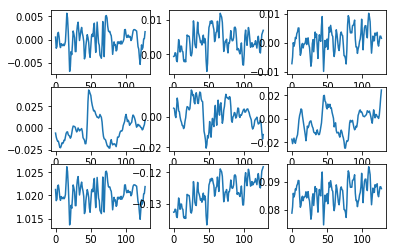

In [62]:
def plot_lines(X, nsamples):
    t = range(128)
    for i in range(9):
        plt.subplot(3,3,i+1)
        for j in range(np.minimum(X.shape[0],nsamples)):
            plt.plot(t,X[j,:,i])
    plt.show()
    
plot_lines(X_train_per_class[5], 1)

In [63]:
# Input Data
training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series

print("(X shape, Y_shape, every X's mean, every X's standard deviation)")
print(X_train.shape, Y_train.shape, np.mean(X_train), np.std(X_train))
print(X_test.shape, Y_test.shape, np.mean(X_test), np.std(X_test))

(X shape, Y_shape, every X's mean, every X's standard deviation)
(7352, 128, 9) (6, 7352) 0.10206611 0.40216514
(2947, 128, 9) (6, 2947) 0.09913992 0.39567086


### Specify and Train the Model

In [64]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2
from keras.optimizers import Adam, RMSprop
from keras.layers import LSTM, RNN, SimpleRNN, Dropout,Flatten

from sklearn import metrics

### Single Layer RNN

Specify a model based on a <code>SimpleRNN</code> (<code>keras.layers.SimpleRNN</code>) followed by a softmax for the classification.

Try different number of units. Do hyper-parameter tuning and report the best test accuracy you can achieve. 

In [65]:
# create and compile model 
### START YOUR CODE 
n_steps = X_train.shape[1]  # 128 timesteps per series
n_input = X_train.shape[2]  # 9 input parameters per timestep

n_hidden = 32
n_classes = 6

model = Sequential()
model.add(SimpleRNN(units=n_hidden, return_sequences=False, input_shape=(n_steps,n_input)))
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

### END YOUR CODE 

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_16 (SimpleRNN)    (None, 32)                1344      
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 198       
Total params: 1,542
Trainable params: 1,542
Non-trainable params: 0
_________________________________________________________________


In [67]:
# train the model
batch_size = 1500
n_epochs = 100
log = model.fit(X_train,Y_train,batch_size=batch_size,epochs=n_epochs,verbose=1,validation_data=(X_test,Y_test))

ValueError: Error when checking target: expected dense_15 to have shape (6,) but got array with shape (7352,)

In [280]:
score, acc = model.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

ValueError: Error when checking target: expected dense_46 to have shape (6,) but got array with shape (2947,)

KeyError: 'val_loss'

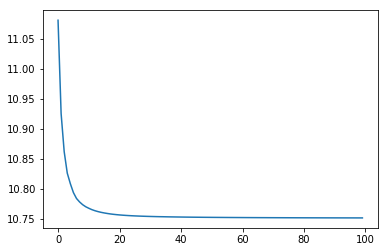

In [281]:
plt.plot(log.history['loss'], label='Training')
plt.plot(log.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

KeyError: 'val_acc'

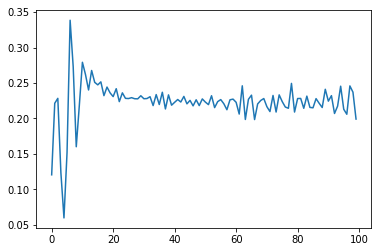

In [282]:
plt.plot(log.history['acc'], label='Training')
plt.plot(log.history['val_acc'], label='Testing')
plt.legend()
plt.grid()

In [38]:
# Compute the confusion matrix
### START YOUR CODE 
predictions = model.predict(X_test)
confusion_matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predictions.argmax(axis=1))
print(confusion_matrix)
### END YOUR CODE 

ValueError: Found input variables with inconsistent numbers of samples: [6, 2947]

### Add Regularisation

Implement L2-Regularisation for <code>SimpleRNN</code> (single layer) and the Softmax Layer. Investigate how you can do that in <code>keras</code>.

Implement Gradient Clipping. Find out how you can do that in <code>keras</code>.

In [36]:
# Specify model incl. L2 regularisation

model = Sequential()
model.add(SimpleRNN(units=n_hidden, return_sequences=False, input_shape=(n_steps,n_input)))
model.add(Dense(n_classes, activation='softmax',kernel_regularizer=l2(0.01)))

### END YOUR CODE 

In [37]:
# Implement gradient clipping and train the model.

rms = RMSprop(lr=0.01, clipvalue=0.5)

model.compile(loss='categorical_crossentropy',optimizer=rms,metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_11 (SimpleRNN)    (None, 32)                1344      
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 198       
Total params: 1,542
Trainable params: 1,542
Non-trainable params: 0
_________________________________________________________________


In [38]:
# Evaluate the results by computing the accuracy and the confusion matrix.

B = 1500
E = 100
log = model.fit(X_train,Y_train,batch_size=B,epochs=E,verbose=1,validation_data=(X_test,Y_test))

ValueError: Error when checking target: expected dense_11 to have shape (6,) but got array with shape (7352,)

### Stacked Layers

Specify a model based on stacked <code>SimpleRNN</code>'s (<code>keras.layers.SimpleRNN</code>) and a Softmax layer for the final classification. 

Again try different number of hidden units, do hyper-parameter tuning and report the best test accuracy you can achieve with two layers. 

In [39]:
### START YOUR CODE 

n_steps = X_train.shape[1]  # 128 timesteps per series
n_input = X_train.shape[2]  # 9 input parameters per timestep

n_hidden = 32
n_classes = 6

model = Sequential()
model.add(SimpleRNN(units=n_hidden, return_sequences=True, input_shape=(n_steps,n_input)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=n_hidden, return_sequences=False, input_shape=(n_steps,n_input)))
model.add(Dropout(0.2))
model.add(Dense(n_classes, activation='softmax',kernel_regularizer=l2(0.01)))

rms = RMSprop(lr=0.01, clipvalue=0.5)

model.compile(loss='categorical_crossentropy',optimizer=rms,metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (None, 128, 32)           1344      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
simple_rnn_13 (SimpleRNN)    (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 198       
Total params: 3,622
Trainable params: 3,622
Non-trainable params: 0
_________________________________________________________________


In [40]:
B = 1500
E = 100
log = model.fit(X_train,Y_train,batch_size=B,epochs=E,verbose=1,validation_data=(X_test,Y_test))

ValueError: Error when checking target: expected dense_12 to have shape (6,) but got array with shape (7352,)

In [41]:
score, acc = model.evaluate(X_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

ValueError: Error when checking target: expected dense_12 to have shape (6,) but got array with shape (2947,)

In [ ]:
plt.plot(log.history['loss'], label='Training')
plt.plot(log.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

In [ ]:
plt.plot(log.history['acc'], label='Training')
plt.plot(log.history['val_acc'], label='Testing')
plt.legend()
plt.grid()

In [ ]:
# Evaluate the results by computing the accuracy and the confusion matrix.
